In [17]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from theano import scan, shared

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


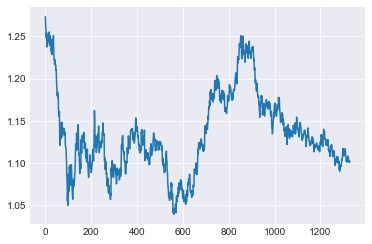

In [3]:
import pandas as pd

data = pd.read_csv("./my_EUR_USD_Hdata.csv")
# print(data)
X=data.as_matrix(columns=['Price'])
price=np.reshape(X,1329)
plt.plot(price)


In [10]:
data['Date']=pd.to_datetime(data['Date'])
data.head()

,Date,Price,Open,High,Low,per_change,Days
0,2014-10-28,1.2734,1.2698,1.2765,1.2683,0.0028,0
1,2014-10-29,1.2632,1.2735,1.2772,1.2631,-0.0080,1
2,2014-10-30,1.2613,1.2631,1.2640,1.2547,-0.0015,2
3,2014-10-31,1.2525,1.2612,1.2618,1.2485,-0.0070,3
4,2014-11-03,1.2483,1.2515,1.2517,1.2441,-0.0034,4


# Applying Augmented Dickey fuller test to EUR_USD data

In [9]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
# series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
X = data['Price'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.193092
p-value: 0.020388
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


# Apply ARMA model

since its already stationary we dont need to apply ARIMA

In [18]:
def build_model():
    y = shared(np.array(data['Price'], dtype=np.float32))
    with pm.Model() as arma_model:
        sigma = pm.HalfNormal('sigma', 5.)
        theta = pm.Normal('theta', 0., sigma=1.)
        phi = pm.Normal('phi', 0., sigma=2.)
        mu = pm.Normal('mu', 0., sigma=10.)

        err0 = y[0] - (mu + phi * mu)
         
        def calc_next(last_y, this_y, err, mu, phi, theta):
            nu_t = mu + phi * last_y + theta * err
            return this_y - nu_t

        err, _ = scan(fn=calc_next,sequences=dict(input=y, taps=[-1, 0]),outputs_info=[err0],non_sequences=[mu, phi, theta])

        pm.Potential('like', pm.Normal.dist(0, sigma=sigma).logp(err))

    return arma_model


In [ ]:
n_samples=1000
model = build_model()
with model:
    trace = pm.sample(draws=n_samples,tune=1000,target_accept=.99)

pm.plots.traceplot(trace)
pm.plots.forestplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
